In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [12]:
def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))
def unit_vector(angle):
    return np.array([np.cos(angle), np.sin(angle)])
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
def render_ep (boat_plot, index=-1, tw_vec=0, target=False):
    from matplotlib import pyplot as plt
    #true wind vector
    #plt.figure(figsize=(10, 6), dpi=200)
    #define plots
    fig, ax = plt.subplots()

    #define coordinates and directions
    if tw_vec.all!=0:
        x = 10
        y = 10
        u = tw_vec[0]
        v = tw_vec[1]

    #create quiver plot
    ax.quiver(x, y, u, v)
    #starting point
    #target point
    #PENDING: spline connecting each point
    
    boat_plot=np.split(boat_plot,len(boat_plot)/2)
    #boat_plot=np.split(boat_plot,len(boat_plot)/2)
    boat_plot=np.array(boat_plot)
    boat_plot=boat_plot[::5]
    # Scatter plot
    #light blue -> darker blue 
    target_plot=env.target_position
    x=boat_plot[:, 0]
    y=boat_plot[:, 1]
    weights = np.arange(1,boat_plot[:, 1].shape[0]+1)
    
    points_size=np.linspace(0.01,9,len(boat_plot))
    plt.scatter(x, y, c=weights, cmap='coolwarm',s=points_size)
    #plt.scatter(figsize=(5, 5))
    if index!=-1:
        plt.title(f"{index}-th episode")
    if target==True:
        plt.scatter(target_plot[0], target_plot[1],c='red',s=0.5)
    # Display the plot
    from matplotlib.pyplot import figure

    
    plt.show()
    #plt.xlim(2*min(x),2*max(x))
    #plt.ylim(2*min(y),2*max(y))




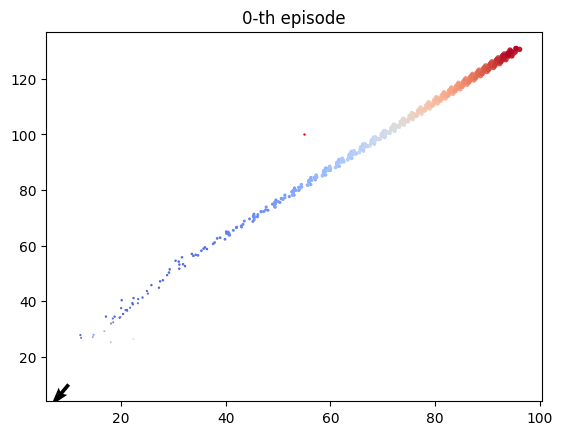

In [13]:
render_ep(boat_plot_all_ep[i],i, vec, True)

In [4]:
import numpy as np

class SailBoatEnvironment:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.35):
        self.step_num=0
        #self.true_wind_direction = np.random.uniform(0, 2*np.pi)
        #PENDING: starting boat pos + target pos kalytera na orizontai sthn init para sthn reset
        #kai h reset na ta pairnei apo tin init
        self.boat_position = np.array([0, 0])
        self.target_position = np.array([55,100])
        #self.target_position = np.array([np.random.uniform(-10, 10), np.random.uniform(-10, 10)])
        self.sail_configs = np.rad2deg(np.linspace(-np.pi/4, np.pi/4, 16)) #16 allowed positions of the sail
        self.rudder_configs = np.linspace(-np.pi/4, np.pi/4, 16) #The values of -np.pi/4 and np.pi/4 are chosen to represent the limits of the rudder configuration. These values correspond to the maximum angles 
                                                                #that the rudder can be turned left and right from the center position.The choice of np.pi/4 as the maximum #
                                                                # angle is somewhat arbitrary, but it is a common choice in sailing and boating applications.
        self.target_possible_angles=np.rad2deg(np.linspace(0, 2*np.pi, 16))
        self.tw_possible_angles=np.rad2deg(np.linspace(0, np.pi, 16))
        
        
        #self.q_table = np.zeros((16, 16, 3))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def reset(self):
        #returns
        #i)boat position: starting point of boat        
        #ii)random wind direction, epistrefei to index sto self.tw_possible_angles
        #iii)ypologizei thn target angle, thn diakritopoiei se mia apo tis dekaksi times kai epistrefei to index
        #toy self.target_possible_angles
        self.step_num=0
        #self.true_wind_direction = self.target_possible_angles[0]
        self.true_wind_direction = self.sail_configs[-1]
        #self.true_wind_direction -> prepei na einai gwnia
        self.true_wind_direction = find_nearest(self.tw_possible_angles, value=self.true_wind_direction)
        self.boat_position = np.array([0, 0]) #fixed starting point
        self.target_position = np.array([55,100]) #fixed target position
        #self.max_distance=np.linalg.norm(self.boat_position-self.target_position)
        self.target_angle=angle_between(self.boat_position, self.target_position)
        self.target_angle=find_nearest(self.target_possible_angles, value=self.target_angle)
        return self.boat_position, np.where(self.true_wind_direction==self.tw_possible_angles)[0][0], \
        np.where(self.target_angle==self.target_possible_angles)[0][0]
        
        

    def get_state(self):
        relative_wind_direction = self.true_wind_direction - np.arctan2(*self.boat_position[::-1])
        #relative_wind_direction = find_nearest(self.target_possible_angles, value=relative_wind_direction)
        distance_to_target = np.linalg.norm(self.boat_position - self.target_position)
        return relative_wind_direction, distance_to_target

    def step(self, action):
        #returns
        #i)boat position: starting point of boat        
        #ii)random wind direction, epistrefei to index sto self.target_possible_angles
        #iii)ypologizei thn target angle, thn diakritopoiei se mia apo tis dekaksi times kai epistrefei to index
        #toy self.target_possible_angles
        #iv) step reward
        #v) done status
        #vi) truncated status
        #vii) number of steps
        sail_config, rudder_config = action
        sail_force = sail_config * np.sin(self.true_wind_direction - np.arctan2(*self.boat_position[::-1]))
        rudder_force = rudder_config * np.cos(self.true_wind_direction - np.arctan2(*self.boat_position[::-1]))
        boat_velocity = np.array([np.cos(self.true_wind_direction), np.sin(self.true_wind_direction)]) * sail_force + np.array([-np.sin(self.true_wind_direction), np.cos(self.true_wind_direction)]) * rudder_force
        self.boat_position = self.boat_position + boat_velocity#.astype(np.float64)
        self.target_angle=angle_between(self.boat_position, self.target_position)
        self.target_angle=find_nearest(self.target_possible_angles, value=self.target_angle)
        
        state = self.get_state()
        self.step_num+=1
        done = False
        truncated = False
        reward = -1

        #if np.any(np.abs(self.boat_position) > 20):
            #done = True
            #reward = -10

        distance_to_target = state[1]
        if distance_to_target < 1:
        #if distance_to_target//self.max_distance < 0.5: #kapws pio sxetiko giati den kseroume to distance 0.5
            #an einia megalo h mikro
            done = True
            reward = 100
        
        if self.step_num >= 2_500:
            truncated = True
            #done = True #gia na spaei h loupa tou training

#         # Q-learning update
#         sail_idx = np.argmin(np.abs(self.sail_configs - sail_config))
#         rudder_idx = np.argmin(np.abs(self.rudder_configs - rudder_config))
#         q_current = self.q_table[sail_idx, rudder_idx, 0]
#         q_next = np.max(self.q_table[sail_idx, rudder_idx, :])
#         self.q_table[sail_idx, rudder_idx, 0] += self.alpha * (reward + self.gamma * q_next - q_current)

        #return boat_velocity, self.boat_position, state, reward, done, self.step_num, self.target_angle
        return self.boat_position, np.where(self.true_wind_direction==self.tw_possible_angles)[0][0],\
        np.where(self.target_angle==self.target_possible_angles)[0][0], reward, \
        done, truncated, self.step_num


In [5]:
env=SailBoatEnvironment()
#current state = true wind direction + angle of boat to target wrt x axis
#prwto einai gia true wind angles
a=len(env.tw_possible_angles)
#deytera gia gwnies pros target
b=len(env.target_possible_angles)
#trito ola ta possible actions
c=32
q_table = np.random.uniform(low=-2, high=0, size=(a,b,c))
#q_table
#wd=0,1,2 # wd=1
#dt=0,1 #dt=0 makria, dt=1 konta
#np.argmax(q_table[1,1])
#
#rudder conf = 0:15th column
#np.argmax(q_table[state,0:15])
#sail conf = 16:31th columns
#np.argmax(q_table[state,16:32])



# Train Q table

0-th ep -> steps: 2500


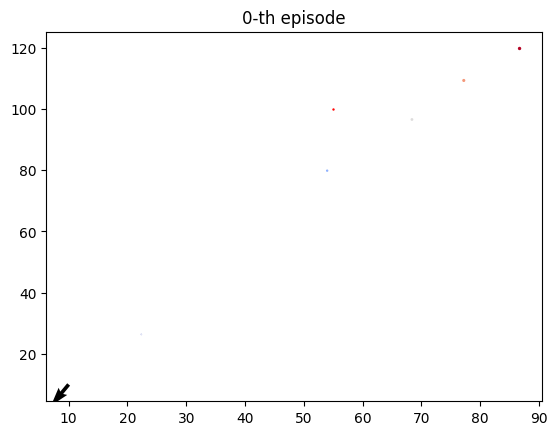

In [6]:
env=SailBoatEnvironment()
EPISODES=1
tw_direction=[]
boat_plot=[]
boat_plot_all_ep=[] #stores all episodes' movement
dones=np.zeros(EPISODES)
for i in range(EPISODES):
    boat_plot=[]
    current_state=env.reset()    
    current_state=current_state[1], current_state[2]
    tw_direction=np.append(tw_direction,current_state[0])
    done=False
    truncated=False
    while not done: # or not truncated:
    #rudder_conf=env.rudder_configs[rudder_conf_index]
    #rudder_conf
        sail_conf_index=np.argmax(q_table[(current_state)][0:16])
        rudder_conf_index=np.argmax(q_table[(current_state)][16:33])
        #print(f"{i} ep: sail index->{sail_conf_index}, rudder index->{rudder_conf_index}")
        #H np.argmax epistrefei index, oxi timh, opote pairnoume to index pou mas epistrefei
        #kai blepoume apo ta *_configs poia timh antistoixei se ayto to index
        action=env.sail_configs[sail_conf_index],env.rudder_configs[rudder_conf_index]
        boat_pos,  true_wind_index, target_angle_index, reward, done, truncated, step_num = env.step(action)
        if done==True:
            print(f"{i}-th ep -> Egina done sto {step_num}-th step.")
            dones[i]=1
            break
        if truncated==True:
            #print(f"{i}-th ep -> Egina truncated")
            break
        new_state=true_wind_index, target_angle_index
        boat_plot=np.append(boat_plot,np.array(boat_pos))
        
        #Psaxnoume ta Q_max, ena gia to sail setting kai ena gia to rudder setting
        #Sto Q table exoume orisei aythaireta oti oi prwtes 16 columns [0:16] dhladh
        #antistoixoun sto sail setting
        #enw oi ypoloipes 16 columns [16:33] sto rudder config
        Q_max_sail=np.max(q_table[(current_state)][0:16])
        Q_max_rudder=np.max(q_table[(current_state)][16:33])
        q_current_sail=q_table[current_state+(sail_conf_index,)]
        q_current_rudder=q_table[current_state+(rudder_conf_index,)]
        new_q_sail=(1-env.alpha)*q_current_sail+env.alpha*(reward+env.gamma*Q_max_sail)
        new_q_rudder=(1-env.alpha)*q_current_rudder+env.alpha*(reward+env.gamma*Q_max_rudder)
        q_table[current_state+(sail_conf_index,)]=new_q_sail
        #15 h 16?
        q_table[current_state+(16+rudder_conf_index,)]=new_q_rudder
        current_state=new_state

    #print(i)
    boat_plot_all_ep.append(boat_plot)
    if i%800==0:
        print(f"{i}-th ep -> steps: {step_num}")
    
#plot last episode
#render_ep(boat_plot, EPISODES)
vec=unit_vector(env.tw_possible_angles[int(tw_direction[i])])
render_ep(boat_plot_all_ep[i],i, vec, True)